In [14]:
import nltk
import zipfile 
nltk.download('brown')
nltk.download('universal_tagset')
import numpy as np
from nltk.corpus import brown
from gensim.models import Word2Vec
from gensim.models import FastText
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from nltk.metrics import ConfusionMatrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.utils.np_utils import to_categorical
universal_tagset = {'ADJ' : 1, 'ADP' : 2, 'ADV' : 3, 'CONJ' : 4, 'DET' : 5, \
                    'NOUN' : 6, 'NUM' : 7, 'PRT' : 8, 'PRON' : 9, 'VERB' : 10,\
                    '.' : 11, 'X' : 12, '0' : 0}

universal_tag = np.array(['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN',\
                             'NUM', 'PRT', 'PRON', 'VERB', '.', 'X'])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
def remove_padding(data, length):
  test_output =[]
  for i in data:
    test_output.append(np.argmax(i))
  final_output = []
  for i in range(length):
    for key, items in universal_tagset.items():
      if test_output[i] == items: final_output.append(key)
  return final_output

In [15]:
def split(input):
  sen = []
  output = input.split(' ')
  for i in output:
    sen.append(i)
  print(sen)  
  return sen

In [3]:
lower_case_sents = []
word_dic = {}
count = 1
for sentence in brown.sents():
  lower_case_sent = []
  for word in sentence:
    if word.lower() not in word_dic:
      word_dic[word.lower()] = count
      count +=1
    lower_case_sent.append(word.lower())
  lower_case_sents.append(lower_case_sent)
corpus_wv = Word2Vec(lower_case_sents, min_count = 1)

embedding_matrix = []
embedding_matrix.append(np.zeros(100))
for word in word_dic.keys():
  embedding_matrix.append(corpus_wv.wv[word])

In [4]:
max_length = max(len(x) for x in brown.sents())
indexed_sents = []
len_matrix = []
for sentence in brown.sents():
  len_matrix.append(len(sentence))
  indexed_sent = []
  for i in range(max_length):
    if i < len(sentence):
      indexed_sent.append(word_dic[sentence[i].lower()])
    else:
      indexed_sent.append(0)
  indexed_sents.append(indexed_sent)
input = indexed_sents

In [5]:
indexed_tags = []
for sentence in brown.tagged_sents(tagset = "universal"):
  indexed_tag = []
  for i in range(max_length):
    if i < len(sentence):
      indexed_tag.append(universal_tagset[sentence[i][1]])
    else:
      indexed_tag.append(0)
  indexed_tags.append(indexed_tag)
output = to_categorical(indexed_tags)

In [6]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)           # main function and Kfold
epoch = 1
accuracies = []
true_tags = []
output_tags = []

for train_index, test_index in kf.split(input, output):         # spliting the kfold in 5 parts
  X = []
  Y = []
  X_test_length = []
  for i in train_index:
    X.append(input[i])
    Y.append(output[i])

  X_test = []
  Y_test = []
  for i in test_index:
    X_test.append(input[i])
    Y_test.append(output[i])
    X_test_length.append(len_matrix[i])

  model = Sequential()
  model.add(Embedding(input_dim = len(word_dic) + 1, output_dim = 100, \
                      input_length = 180, weights = [np.array(embedding_matrix)], \
                      trainable = True))
  model.add(Dense(13, activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer =  'adam', metrics   =  ['accuracy'])
  model.fit(np.array(X), np.array(Y), batch_size=128, epochs=5, verbose = False)
  
  evaulation = model.evaluate(np.array(X_test), np.array(Y_test), batch_size=128, verbose = False)
  print("Accuracy for fold", epoch ,":", evaulation[1]*100)
  accuracies.append(evaulation[1]*100)
  prediction = model.predict(np.array(X_test))
  for i in range(len(X_test)):
    true_tags.append(remove_padding(Y_test[i], X_test_length[i]))
    output_tags.append(remove_padding(prediction[i], X_test_length[i]))
  epoch+=1
print("Average accuary of K-Fold valiavtion : ", sum(accuracies)/5)

Accuracy for fold 1 : 99.37924146652222
Accuracy for fold 2 : 99.37856197357178
Accuracy for fold 3 : 99.38006401062012
Accuracy for fold 4 : 99.37318563461304
Accuracy for fold 5 : 99.37381148338318
Average accuary of K-Fold valiavtion :  99.37697291374207


In [7]:
t = true_tags
o = output_tags

In [8]:
true_tags = []
output_tags= []
for i in t:
  for j in i: true_tags.append(j)

for i in o:
  for j in i: output_tags.append(j)

In [9]:
print("Confusion Matrix:")
print(ConfusionMatrix(true_tags, output_tags))

print()
print()

p = precision_score(true_tags, output_tags, average = None, labels = universal_tag)
for i in range(len(universal_tag)):
  print("Precision of ", universal_tag[i], " : ", p[i])

print()
print()

r = recall_score(true_tags, output_tags, average = None, labels = universal_tag)
for i in range(len(universal_tag)):
  print("Recall of ", universal_tag[i], " : ", r[i])

print()
print()

f1 = fbeta_score(true_tags, output_tags, average = None, beta=1.0, labels = universal_tag)
for i in range(len(universal_tag)):
  print("F1 Score of ", universal_tag[i], " : ", f1[i])

Confusion Matrix:
     |                                         C             N             P             V        |
     |                    A      A      A      O      D      O      N      R      P      E        |
     |                    D      D      D      N      E      U      U      O      R      R        |
     |      .      0      J      P      V      J      T      N      M      N      T      B      X |
-----+--------------------------------------------------------------------------------------------+
   . |<147565>     .      .      .      .      .      .      .      .      .      .      .      . |
   0 |      .     <.>     .      .      .      .      .      .      .      .      .      .      . |
 ADJ |      .     85 <73073>   135   3350      .      .   6690      3      .      6    376      3 |
 ADP |     20      1    119<131438>   748    148      1    104      1      .  12141     44      1 |
 ADV |      .     23   2501   3030 <48520>    68    361    888      .      2    84

In [10]:
p = precision_score(true_tags, output_tags, average = "weighted", labels = universal_tag)
r = recall_score(true_tags, output_tags, average = "weighted", labels = universal_tag)
f_point_five = fbeta_score(true_tags, output_tags, beta=0.5, average = "weighted", labels = universal_tag)
f_one = fbeta_score(true_tags, output_tags, beta=1.0, average = "weighted", labels = universal_tag)
f_two = fbeta_score(true_tags, output_tags, beta=2.0, average = "weighted", labels = universal_tag)

print('Overall performance: \n Precision = %f, \n Recall = %f,'\
      ' \n F0.5 Score = %f, \n F1 Score = %f, \n F2 Score = %f'\
      % (p, r, f_point_five,f_one,f_two))

Overall performance: 
 Precision = 0.947640, 
 Recall = 0.944622, 
 F0.5 Score = 0.946409, 
 F1 Score = 0.945197, 
 F2 Score = 0.944626


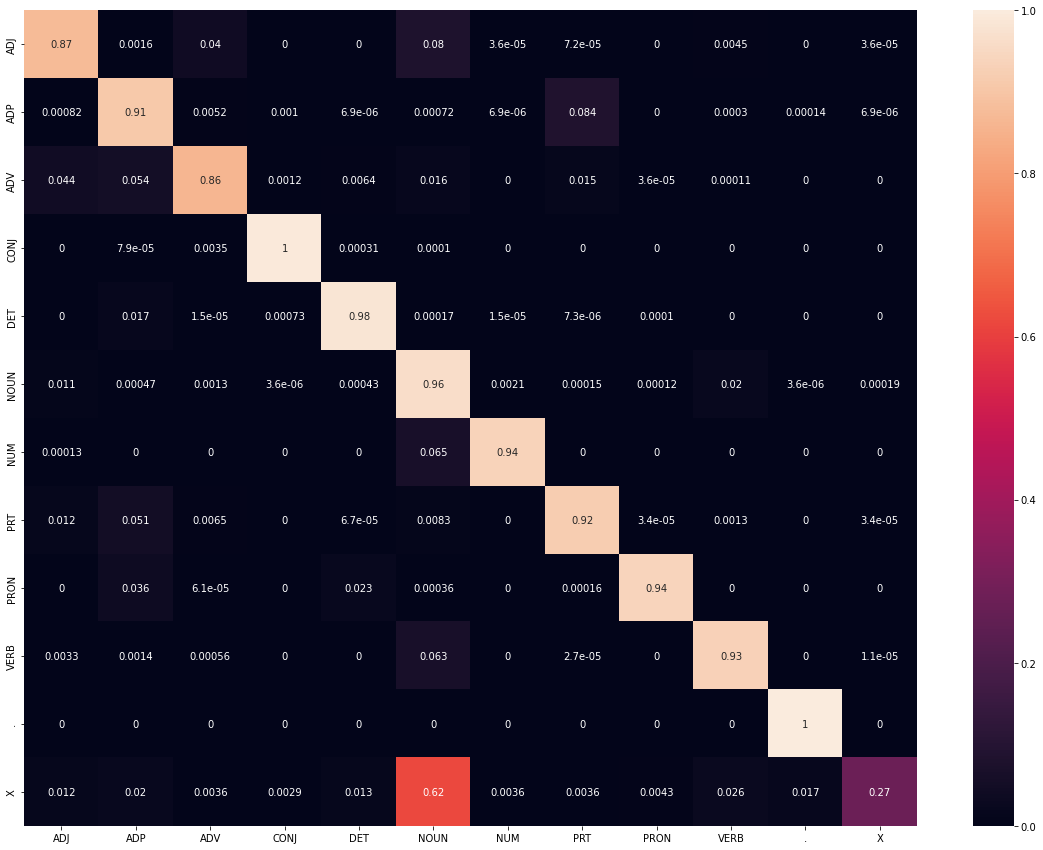

In [11]:
plt.figure(figsize = (20,15))
cm = confusion_matrix(true_tags, output_tags, labels = universal_tag)
cm_nor = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(pd.DataFrame(cm_nor, index = universal_tag, columns = universal_tag), annot=True)

In [16]:
corpus_wv = FastText(lower_case_sents, min_count = 1)

In [20]:
def predict(testing):
  test_input = []
  for i in range(max_length):
    if i < len(testing):
      if testing[i].lower() in word_dic:
        test_input.append(word_dic[testing[i].lower()])
      else:
        oov = corpus_wv.wv[word]
        guesses, prob = zip(*corpus_wv.wv.most_similar([oov], []))
        for guess in guesses:
          if guess in word_dic:
            test_input.append(word_dic[guess.lower()])
            break
          else: test_input.append(0)
    else: test_input.append(0)
  x = model.predict(np.array(test_input))
  test_output =[]
  for i in x:
    test_output.append(np.argmax(i))
  final_output = []
  for i in range(len(testing)):
    for key, items in universal_tagset.items():
      if test_output[i] == items: final_output.append(key)
  return final_output

In [22]:
predict(split('Mumbai and Delhi rad is very nice'))

['Mumbai', 'and', 'Delhi', 'rad', 'is', 'very', 'nice']


['NOUN', 'CONJ', 'NOUN', 'NOUN', 'VERB', 'ADV', 'ADJ']